# AUTOENCODERS IMPLEMENTATION

***Create a simple autoencoder using TensorFlow to reconstruct images from the Covid19 Radiography dataset.***

- Ayushmaan Das (E012037)

Dataset: https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database


<hr>

### Importing the required Modules

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

<hr>

### Fetching the Data from Kaggle programmatically

In [ ]:
!curl -L -o covid19-radiography-database.zip\
  https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  778M  100  778M    0     0  74.0M      0  0:00:10  0:00:10 --:--:-- 74.1M


In [ ]:
!unzip covid19-radiography-database.zip

<hr>

### Data Preparation and Loading the Images

(Using small subset of original data due to low computational resources)

In [ ]:
dataset_path = "Covid-19 Data"
image_size = (128, 128)
batch_size = 32

- Creating a smaller subset of data

In [ ]:
def load_subset_of_images(folder, num_images=2500, image_size=(128, 128)):
    images = []
    filenames = os.listdir(folder)
    selected_files = np.random.choice(filenames, size=num_images, replace=False)
    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

- Separating the two classes of the images

In [ ]:
num_images_per_class = 2500
covid_images = load_subset_of_images(os.path.join(dataset_path, 'COVID'), num_images=num_images_per_class)
normal_images = load_subset_of_images(os.path.join(dataset_path, 'Normal'), num_images=num_images_per_class)

- Normalization

In [ ]:
covid_images = covid_images / 255.0
normal_images = normal_images / 255.0

- Training Data

In [ ]:
X_data = np.concatenate([covid_images, normal_images], axis=0)

<hr>

### Autoencoder Model

In [ ]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

- Compilation

In [ ]:
input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

- Training

In [ ]:
train_data = X_data[:int(0.8 * len(X_data))]
val_data = X_data[int(0.8 * len(X_data)):]

In [ ]:
epochs = 10
history = autoencoder.fit(
    train_data, train_data,
    validation_data=(val_data, val_data),
    epochs=epochs,
    batch_size=32
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 5.1321e-04 - val_loss: 5.7338e-04
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.4156e-04 - val_loss: 6.2650e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 5.3237e-04 - val_loss: 5.5242e-04
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.0532e-04 - val_loss: 5.7309e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.9105e-04 - val_loss: 5.5895e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.9732e-04 - val_loss: 5.2774e-04
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 4.8755e-04 - val_loss: 5.1484e-04
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.0748e-04 - val_loss: 5.0889e-04
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 4.7980e-04 - val_loss: 4.9983e-04
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.5008e-04 - val_loss: 5.0404e-04


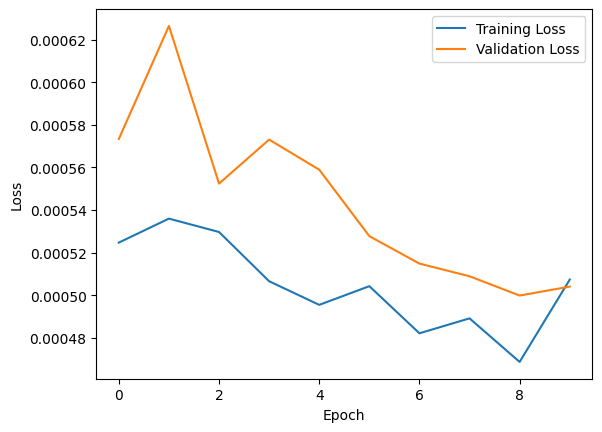

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<hr>

### Displaying reconstructed images

In [ ]:
def display_reconstructed_images(model, data):
    reconstructed_images = model.predict(data[:10])

    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original image
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(data[i])
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed_images[i])
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


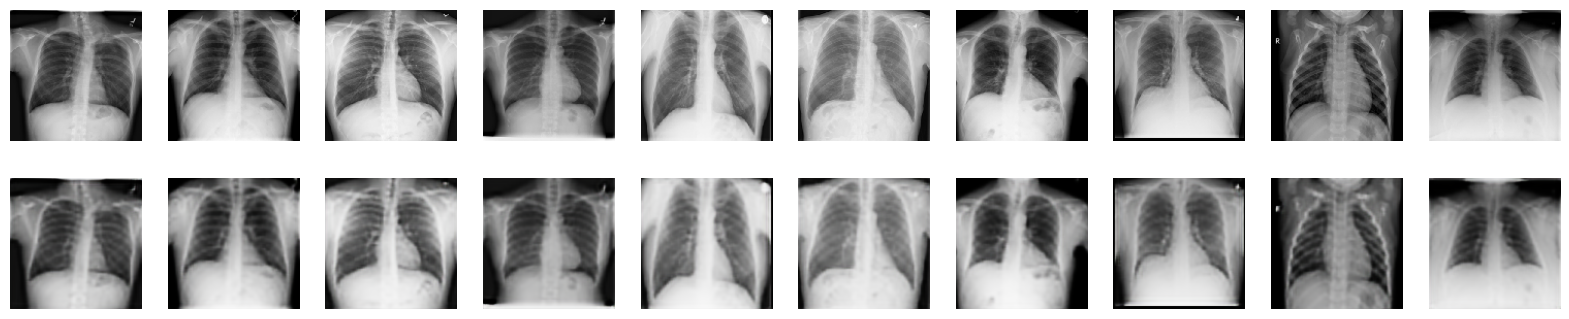

In [ ]:
display_reconstructed_images(autoencoder, val_data)

<hr>